In [4]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah

def calculate_sky_area_90_percent_positions(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to angular coordinates (θ, φ)
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    
    # Convert θ, φ to RA and Dec
    ra_deg = np.degrees(phi)  # RA in degrees
    dec_deg = np.degrees(0.5 * np.pi - theta)  # Dec in degrees
    
    # Create a structured array to store pixel index, RA, and Dec
    pixel_positions = np.zeros(len(pixels_in_target_percent), dtype=[('pixel_index', int), ('ra_deg', float), ('dec_deg', float)])
    pixel_positions['pixel_index'] = pixels_in_target_percent
    pixel_positions['ra_deg'] = ra_deg
    pixel_positions['dec_deg'] = dec_deg
    
    return pixel_positions

# Example usage
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
target_probability = 0.1
pixel_positions_in_90_percent = calculate_sky_area_90_percent_positions(skymap_file, target_probability)

# Print the first few pixel positions within the 90% region
for i in range( len(pixel_positions_in_90_percent)):
    print(f"Pixel {pixel_positions_in_90_percent['pixel_index'][i]}: RA = {pixel_positions_in_90_percent['ra_deg'][i]:.6f} deg, Dec = {pixel_positions_in_90_percent['dec_deg'][i]:.6f} deg")


Pixel 2988690: RA = 103.660714 deg, Dec = -64.198746 deg
Pixel 2988691: RA = 103.982143 deg, Dec = -64.198746 deg
Pixel 2990923: RA = 103.435252 deg, Dec = -64.386184 deg
Pixel 2990922: RA = 103.111511 deg, Dec = -64.386184 deg
Pixel 2987570: RA = 104.572954 deg, Dec = -64.105000 deg
Pixel 2989808: RA = 103.387097 deg, Dec = -64.292474 deg
Pixel 2989809: RA = 103.709677 deg, Dec = -64.292474 deg
Pixel 2986442: RA = 104.202128 deg, Dec = -64.011237 deg
Pixel 2987568: RA = 103.932384 deg, Dec = -64.105000 deg
Pixel 2986443: RA = 104.521277 deg, Dec = -64.011237 deg
Pixel 2988689: RA = 103.339286 deg, Dec = -64.198746 deg
Pixel 2987569: RA = 104.252669 deg, Dec = -64.105000 deg
Pixel 2988692: RA = 104.303571 deg, Dec = -64.198746 deg
Pixel 2985313: RA = 104.787986 deg, Dec = -63.917456 deg
Pixel 2990924: RA = 103.758993 deg, Dec = -64.386184 deg
Pixel 2986441: RA = 103.882979 deg, Dec = -64.011237 deg
Pixel 2989807: RA = 103.064516 deg, Dec = -64.292474 deg
Pixel 2987567: RA = 103.612100 

In [15]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        dist_mu = skymap['DISTMU'][idx] 
        dist_sigma = skymap['DISTSIGMA'][idx] 
        dist_mu = np.array(dist_mu)
        dist_sigma = np.array(dist_sigma)
       
        
        # Calculate the minimum and maximum distances
        r_min = max(0, dist_mu - dist_sigma)  # to ensure distance is non-negative
        r_max = dist_mu + dist_sigma
        pixel_area_sr = hp.nside2pixarea(nside)
        pixel_area_deg2 = pixel_area_sr * (180 / np.pi)**2
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / 10**12
        # Calculate the volume for this pixel
        volumes[i] = area_mpc2 * (r_max - r_min) # Mpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Mpc3', float), ('r_min', float), ('r_max', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Mpc3'] = volumes
    pixel_volumes['r_min'] = skymap['DISTMU'][matched_indices] - skymap['DISTSIGMA'][matched_indices]
    pixel_volumes['r_max'] = skymap['DISTMU'][matched_indices] + skymap['DISTSIGMA'][matched_indices]
    
    return pixel_volumes
# Example usage
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
target_probability = 0.1
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Mpc3'][i]:.6f} Mpc^3, r_min = {pixel_volumes_in_90_percent['r_min'][i]:.2f} Mpc, r_max = {pixel_volumes_in_90_percent['r_max'][i]:.2f} Mpc")

Pixel 17554: Volume = 0.001786 Mpc^3, r_min = 15.18 Mpc, r_max = 769.44 Mpc
Pixel 17553: Volume = 0.001786 Mpc^3, r_min = 16.66 Mpc, r_max = 770.79 Mpc
Pixel 17549: Volume = 0.001789 Mpc^3, r_min = 16.07 Mpc, r_max = 771.74 Mpc
Pixel 17550: Volume = 0.001790 Mpc^3, r_min = 14.68 Mpc, r_max = 770.45 Mpc
Pixel 17543: Volume = 0.001784 Mpc^3, r_min = 18.10 Mpc, r_max = 771.58 Mpc


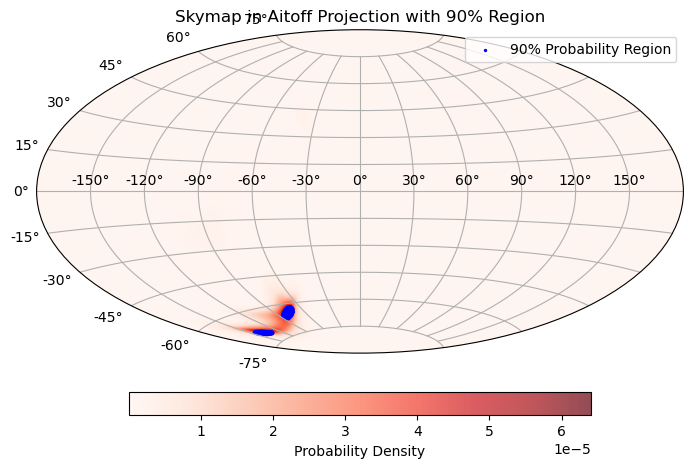

Number of pixels in 90% region: 1891
Matching pixels found: 1891
Number of pixels in 90% region: 1891
Matching pixels found: 1891
Pixel 17554: Volume = 0.001786 Mpc^3, r_min = 15.18 Mpc, r_max = 769.44 Mpc
Pixel 17553: Volume = 0.001786 Mpc^3, r_min = 16.66 Mpc, r_max = 770.79 Mpc
Pixel 17549: Volume = 0.001789 Mpc^3, r_min = 16.07 Mpc, r_max = 771.74 Mpc
Pixel 17550: Volume = 0.001790 Mpc^3, r_min = 14.68 Mpc, r_max = 770.45 Mpc
Pixel 17543: Volume = 0.001784 Mpc^3, r_min = 18.10 Mpc, r_max = 771.58 Mpc
Converted volumes in Gpc^3: [1.78613214e-12 1.78584102e-12 1.78947187e-12 ... 1.86124874e-12
 1.88382852e-12 1.86449400e-12]
Total volume in the 90% probability region: 3.487168e-09 Gpc^3

Sampled transients in the enclosed region:
SNIa: 8.194845798587532e-05
CCSN: 0.0003522040109180182
SLSN: 1.9528143179612927e-08
KN: 1.7435842124654374e-05
GRB_on_axis: 3.4871684249308746e-09
GRB_off_axis: 2.441017897451611e-08
CV: 0.00348716842493088


In [50]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah
import numpy as np
import healpy as hp
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
import matplotlib.pyplot as plt

def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    # Match RA and Dec within some tolerance (e.g., 1e-6 degrees)
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(skymap_pixels_in_target_percent)}")
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(matched_indices)}")
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        dist_mu = skymap['DISTMU'][idx] 
        dist_sigma = skymap['DISTSIGMA'][idx] 
        dist_mu = np.array(dist_mu)
        dist_sigma = np.array(dist_sigma)
        prob_density = skymap['PROBDENSITY'][idx]
        prob = np.array(prob_density)
       
        
        # Calculate the minimum and maximum distances
        r_min = dist_mu - dist_sigma # to ensure distance is non-negative
        r_max = dist_mu + dist_sigma
        pixel_area_deg2 = hp.nside2pixarea(nside, degrees = True)
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / (10**12)
        # Calculate the volume for this pixel
        volumes[i] = area_mpc2 * (r_max - r_min)  # Mpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Mpc3', float), ('r_min', float), ('r_max', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Mpc3'] = volumes
    pixel_volumes['r_min'] = skymap['DISTMU'][matched_indices] - skymap['DISTSIGMA'][matched_indices]
    pixel_volumes['r_max'] = skymap['DISTMU'][matched_indices] + skymap['DISTSIGMA'][matched_indices]
    
    return pixel_volumes
    
def calculate_expected_transients(volumes, transients_rates):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            expected_events = rate * volume 
            total_expected_transients[transient] += expected_events
    
    return total_expected_transients

def sample_transients(expected_transients):
    sampled_transients = {transient: np.random.poisson(lam=total_count)
                          for transient, total_count in expected_transients.items()}
    return sampled_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    # Convert HEALPix coordinates to equatorial coordinates for Aitoff projection
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta

    # Adjust the range of ra_rad to [-pi, pi] for Aitoff projection
    ra_rad = ra_rad - np.pi

    # Convert the selected pixels back to RA and Dec for plotting
    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    

    # Create the Aitoff projection plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    # Plot the skymap
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)

    # Plot the specific 90% probability region
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'  
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}

# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Mpc3'][i]:.6f} Mpc^3, r_min = {pixel_volumes_in_90_percent['r_min'][i]:.2f} Mpc, r_max = {pixel_volumes_in_90_percent['r_max'][i]:.2f} Mpc")


# Convert volumes to Gpc^3
volumes_gpc3 = pixel_volumes_in_90_percent['volume_Mpc3'] * 1e-9
print(f"Converted volumes in Gpc^3: {volumes_gpc3}")
# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Mpc3']) * 1e-9
print(f"Total volume in the 90% probability region: {total_volume:.6e} Gpc^3")

# Calculate expected transients in the 90% probability region
total_expected_transients = calculate_expected_transients(volumes_gpc3, transients_rates)

# Sample the number of transients based on expected values
sampled_transients = sample_transients(total_expected_transients)

# Print the sampled number of transients
print("\nSampled transients in the enclosed region:")
for transient, sampled_count in total_expected_transients.items():
    print(f"{transient}: {sampled_count}")

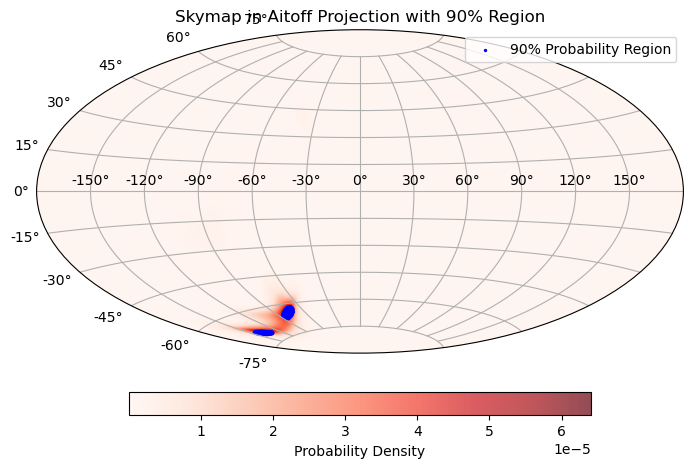

Number of pixels in 90% region: 1891
Matching pixels found: 1891
Number of pixels in 90% region: 1891
Matching pixels found: 1891
Pixel 17554: Volume = 0.001786 Mpc^3, r_min = 15.18 Mpc, r_max = 769.44 Mpc
Pixel 17553: Volume = 0.001786 Mpc^3, r_min = 16.66 Mpc, r_max = 770.79 Mpc
Pixel 17549: Volume = 0.001789 Mpc^3, r_min = 16.07 Mpc, r_max = 771.74 Mpc
Pixel 17550: Volume = 0.001790 Mpc^3, r_min = 14.68 Mpc, r_max = 770.45 Mpc
Pixel 17543: Volume = 0.001784 Mpc^3, r_min = 18.10 Mpc, r_max = 771.58 Mpc
Converted volumes in Gpc^3: [1.78613214e-12 1.78584102e-12 1.78947187e-12 ... 1.86124874e-12
 1.88382852e-12 1.86449400e-12]
Total volume in the 90% probability region: 3.487168e-09 Gpc^3

Sampled transients in the enclosed region:
SNIa: 0
CCSN: 0
SLSN: 0
KN: 0
GRB_on_axis: 0
GRB_off_axis: 0
CV: 0


In [55]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah
import numpy as np
import healpy as hp
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
import matplotlib.pyplot as plt


def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    # Match RA and Dec within some tolerance (e.g., 1e-6 degrees)
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(skymap_pixels_in_target_percent)}")
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(matched_indices)}")
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        dist_mu = skymap['DISTMU'][idx] 
        dist_sigma = skymap['DISTSIGMA'][idx] 
        dist_mu = np.array(dist_mu)
        dist_sigma = np.array(dist_sigma)
        prob_density = skymap['PROBDENSITY'][idx]
        prob = np.array(prob_density)
       
        
        # Calculate the minimum and maximum distances
        r_min = dist_mu - dist_sigma # to ensure distance is non-negative
        r_max = dist_mu + dist_sigma
        pixel_area_sr = hp.nside2pixarea(nside)
        pixel_area_deg2 = pixel_area_sr * (180 / np.pi)**2
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / (10**12)
        # Calculate the volume for this pixel
        volumes[i] = area_mpc2 * (r_max - r_min)  # Mpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Mpc3', float), ('r_min', float), ('r_max', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Mpc3'] = volumes
    pixel_volumes['r_min'] = skymap['DISTMU'][matched_indices] - skymap['DISTSIGMA'][matched_indices]
    pixel_volumes['r_max'] = skymap['DISTMU'][matched_indices] + skymap['DISTSIGMA'][matched_indices]
    
    return pixel_volumes
    
def calculate_expected_transients(volumes, transients_rates):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            expected_events = rate * volume 
            total_expected_transients[transient] += expected_events
    
    return total_expected_transients

def sample_transients(expected_transients):
    sampled_transients = {transient: np.random.poisson(lam=total_count)
                          for transient, total_count in expected_transients.items()}
    return sampled_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    # Convert HEALPix coordinates to equatorial coordinates for Aitoff projection
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta

    # Adjust the range of ra_rad to [-pi, pi] for Aitoff projection
    ra_rad = ra_rad - np.pi

    # Convert the selected pixels back to RA and Dec for plotting
    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    

    # Create the Aitoff projection plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    # Plot the skymap
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)

    # Plot the specific 90% probability region
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'  
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}

# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Mpc3'][i]:.6f} Mpc^3, r_min = {pixel_volumes_in_90_percent['r_min'][i]:.2f} Mpc, r_max = {pixel_volumes_in_90_percent['r_max'][i]:.2f} Mpc")


# Convert volumes to Gpc^3
volumes_gpc3 = pixel_volumes_in_90_percent['volume_Mpc3'] * 1e-9
print(f"Converted volumes in Gpc^3: {volumes_gpc3}")
# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Mpc3']) * 1e-9
print(f"Total volume in the 90% probability region: {total_volume:.6e} Gpc^3")

# Calculate expected transients in the 90% probability region
total_expected_transients = calculate_expected_transients(volumes_gpc3, transients_rates)

# Sample the number of transients based on expected values
sampled_transients = sample_transients(total_expected_transients)

# Print the sampled number of transients
print("\nSampled transients in the enclosed region:")
for transient, sampled_count in sampled_transients.items():
    print(f"{transient}: {sampled_count}")

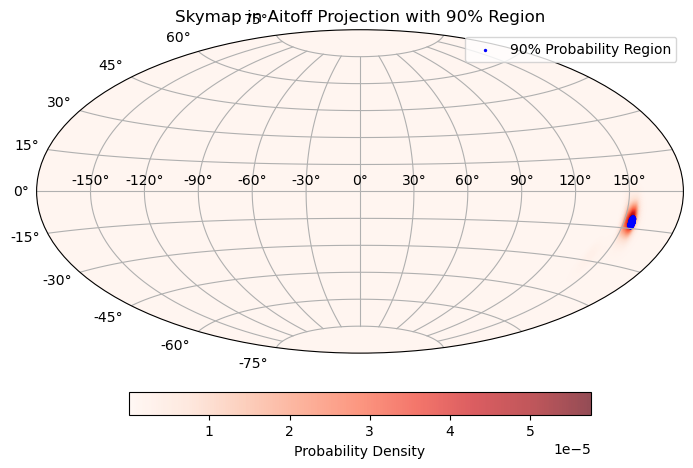

Number of pixels in 90% region: 1881
Matching pixels found: 1881
Number of pixels in 90% region: 1881
Matching pixels found: 1881
Pixel 18009: Volume = 612659630.013039 Mpc^3, r_min = 272.76 Mpc, r_max = 550.20 Mpc
Pixel 18002: Volume = 611569205.381140 Mpc^3, r_min = 272.63 Mpc, r_max = 549.88 Mpc
Pixel 18054: Volume = 613791832.454348 Mpc^3, r_min = 272.89 Mpc, r_max = 550.53 Mpc
Pixel 17997: Volume = 610518968.055189 Mpc^3, r_min = 272.49 Mpc, r_max = 549.57 Mpc
Pixel 18077: Volume = 614965650.760702 Mpc^3, r_min = 273.01 Mpc, r_max = 550.87 Mpc
Converted volumes in Gpc^3: [0.61265963 0.61156921 0.61379183 ... 0.67106148 0.66403591 0.66452365]
Total volume in the 90% probability region: 1.166634e+03 Gpc^3

Sampled transients in the enclosed region:
SNIa: 27411680
CCSN: 117832042
SLSN: 6515
KN: 5836679
GRB_on_axis: 1177
GRB_off_axis: 8103
CV: 1166680598


In [49]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah
import numpy as np
import healpy as hp
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
import matplotlib.pyplot as plt

def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    # Match RA and Dec within some tolerance (e.g., 1e-6 degrees)
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(skymap_pixels_in_target_percent)}")
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(matched_indices)}")
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        dist_mu = skymap['DISTMU'][idx] 
        dist_sigma = skymap['DISTSIGMA'][idx] 
        dist_mu = np.array(dist_mu)
        dist_sigma = np.array(dist_sigma)
        prob_density = skymap['PROBDENSITY']
        prob = np.array(prob_density)
       
        
        # Calculate the minimum and maximum distances
        r_min = max(0, dist_mu - dist_sigma)  # to ensure distance is non-negative
        r_max = dist_mu + dist_sigma
        pixel_area_sr = hp.nside2pixarea(nside)
        pixel_area_deg2 = pixel_area_sr * (180 / np.pi)**2
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / 10**12
        # Calculate the volume for this pixel
        volumes[i] = (4/3) * np.pi * (r_max**3 - r_min**3) # Mpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Mpc3', float), ('r_min', float), ('r_max', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Mpc3'] = volumes
    pixel_volumes['r_min'] = skymap['DISTMU'][matched_indices] - skymap['DISTSIGMA'][matched_indices]
    pixel_volumes['r_max'] = skymap['DISTMU'][matched_indices] + skymap['DISTSIGMA'][matched_indices]
    
    return pixel_volumes
    
def calculate_expected_transients(volumes, transients_rates):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            expected_events = rate * volume 
            total_expected_transients[transient] += expected_events
    
    return total_expected_transients

def sample_transients(expected_transients):
    sampled_transients = {transient: np.random.poisson(lam=total_count)
                          for transient, total_count in expected_transients.items()}
    return sampled_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    # Convert HEALPix coordinates to equatorial coordinates for Aitoff projection
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta

    # Adjust the range of ra_rad to [-pi, pi] for Aitoff projection
    ra_rad = ra_rad - np.pi

    # Convert the selected pixels back to RA and Dec for plotting
    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    

    # Create the Aitoff projection plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    # Plot the skymap
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)

    # Plot the specific 90% probability region
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/60.fits'  
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}

# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Mpc3'][i]:.6f} Mpc^3, r_min = {pixel_volumes_in_90_percent['r_min'][i]:.2f} Mpc, r_max = {pixel_volumes_in_90_percent['r_max'][i]:.2f} Mpc")


# Convert volumes to Gpc^3
volumes_gpc3 = pixel_volumes_in_90_percent['volume_Mpc3'] * 1e-9
print(f"Converted volumes in Gpc^3: {volumes_gpc3}")
# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Mpc3']) * 1e-9
print(f"Total volume in the 90% probability region: {total_volume:.6e} Gpc^3")

# Calculate expected transients in the 90% probability region
total_expected_transients = calculate_expected_transients(volumes_gpc3, transients_rates)

# Sample the number of transients based on expected values
sampled_transients = sample_transients(total_expected_transients)

# Print the sampled number of transients
print("\nSampled transients in the enclosed region:")
for transient, sampled_count in sampled_transients.items():
    print(f"{transient}: {sampled_count}")